# Overview of Assignment 2

This assignment explores fundamental concepts and techniques for image retrieval. The main objective is to develop an image retrieval system that efficiently searches a database to find visually similar images to a query image. This will involve implementing and comparing different feature extraction methods, similarity measures, and indexing structures covered in lectures.

#   Enter your details below

# Name

Sofia Jia

# Banner ID

B00894664

# Q1: Setting up the libraries and environment

**a.**

In [2]:
pip install torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [12]:
import torch
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2

**b.**

In [4]:
# normalize
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# split the dataset into train & test
train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='mnist_data', train=False, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11590625.08it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 391386.52it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3860747.09it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5409008.74it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



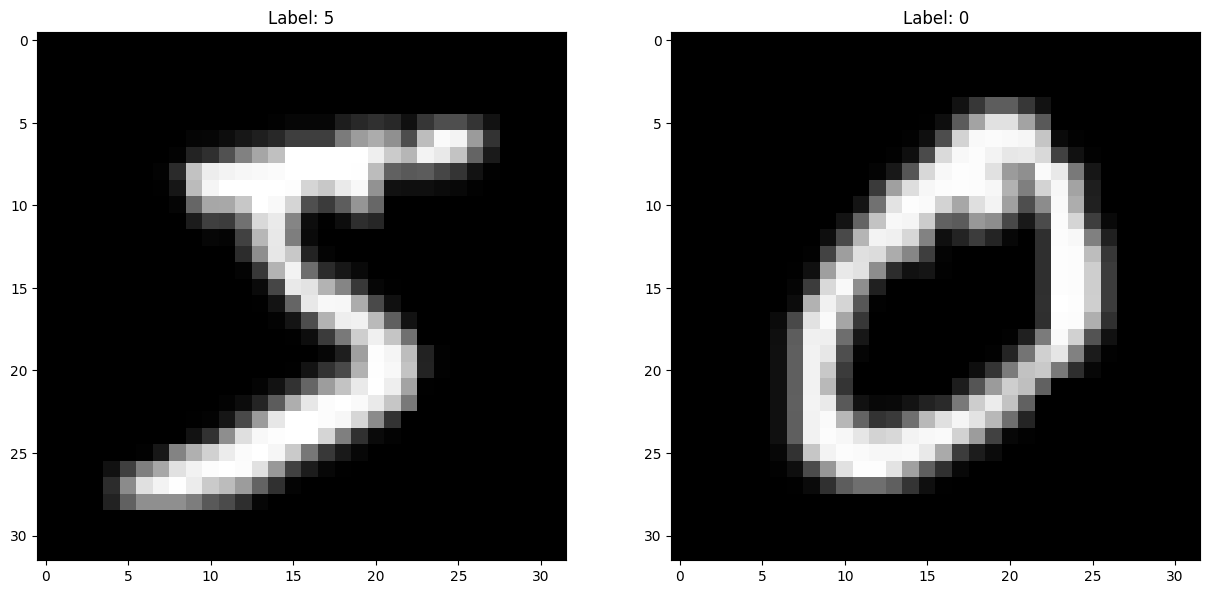

In [5]:
# display sample images and metadata
def show_samples(dataset, num_samples=2):
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 15))
    for i in range(num_samples):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # Convert from CHW to HWC for display
        axs[i].imshow(image.numpy().squeeze(), cmap='gray')
        axs[i].set_title(f'Label: {label}')
    plt.show()

# Show samples from the training dataset
show_samples(train_dataset)

For the pre-processing steps I applied normolization on the images by re-sizing them, convert color scheme to grey scale and normalize the pixels.

# Q2: Feature Extraction

**1. a**

In [6]:
pip install opencv-python-headless

In [7]:
# SIFT
def extract_and_visualize_sift(image):
    # Convert the image to a NumPy array and then to a format suitable for OpenCV
    image_np = image.permute(1, 2, 0).numpy()  # Convert from CHW to HWC
    image_np = (image_np * 255).astype(np.uint8)  # Convert from range [-1, 1] to [0, 255]
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_GRAY2BGR)  # Convert to 3-channel BGR for visualization

    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image_bgr, None)

    # Draw keypoints on the image
    image_with_keypoints = cv2.drawKeypoints(image_bgr, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return image_with_keypoints, keypoints, descriptors

**1. b**

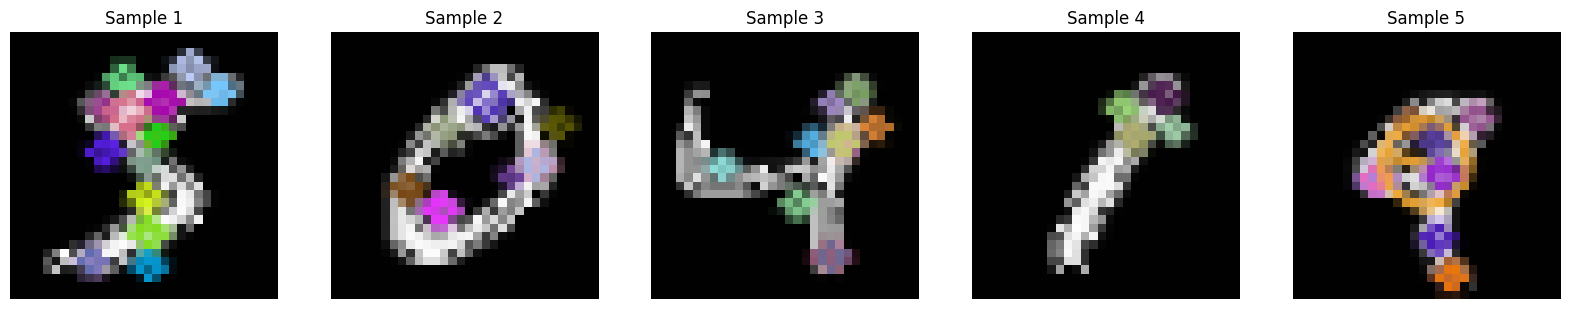

In [8]:
def visualize_sample_images(dataset, num_samples=5):
    fig, axs = plt.subplots(1, num_samples, figsize=(20, 5))
    for i in range(num_samples):
        image, _ = dataset[i]
        image_with_keypoints, keypoints, _ = extract_and_visualize_sift(image)
        axs[i].imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
        axs[i].set_title(f'Sample {i+1}')
        axs[i].axis('off')
    plt.show()

# Visualize a few sample images with SIFT key points
visualize_sample_images(train_dataset)

The dominant orientation is assigned to each keypoints to achieve rotation invariance. Scale invariance is also achieved through keypoints by seleting keypoints using keypoint descriptors

**2. a**

In [9]:
# CNN

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match VGG16 input size
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])
CNN_train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 62.1MB/s]


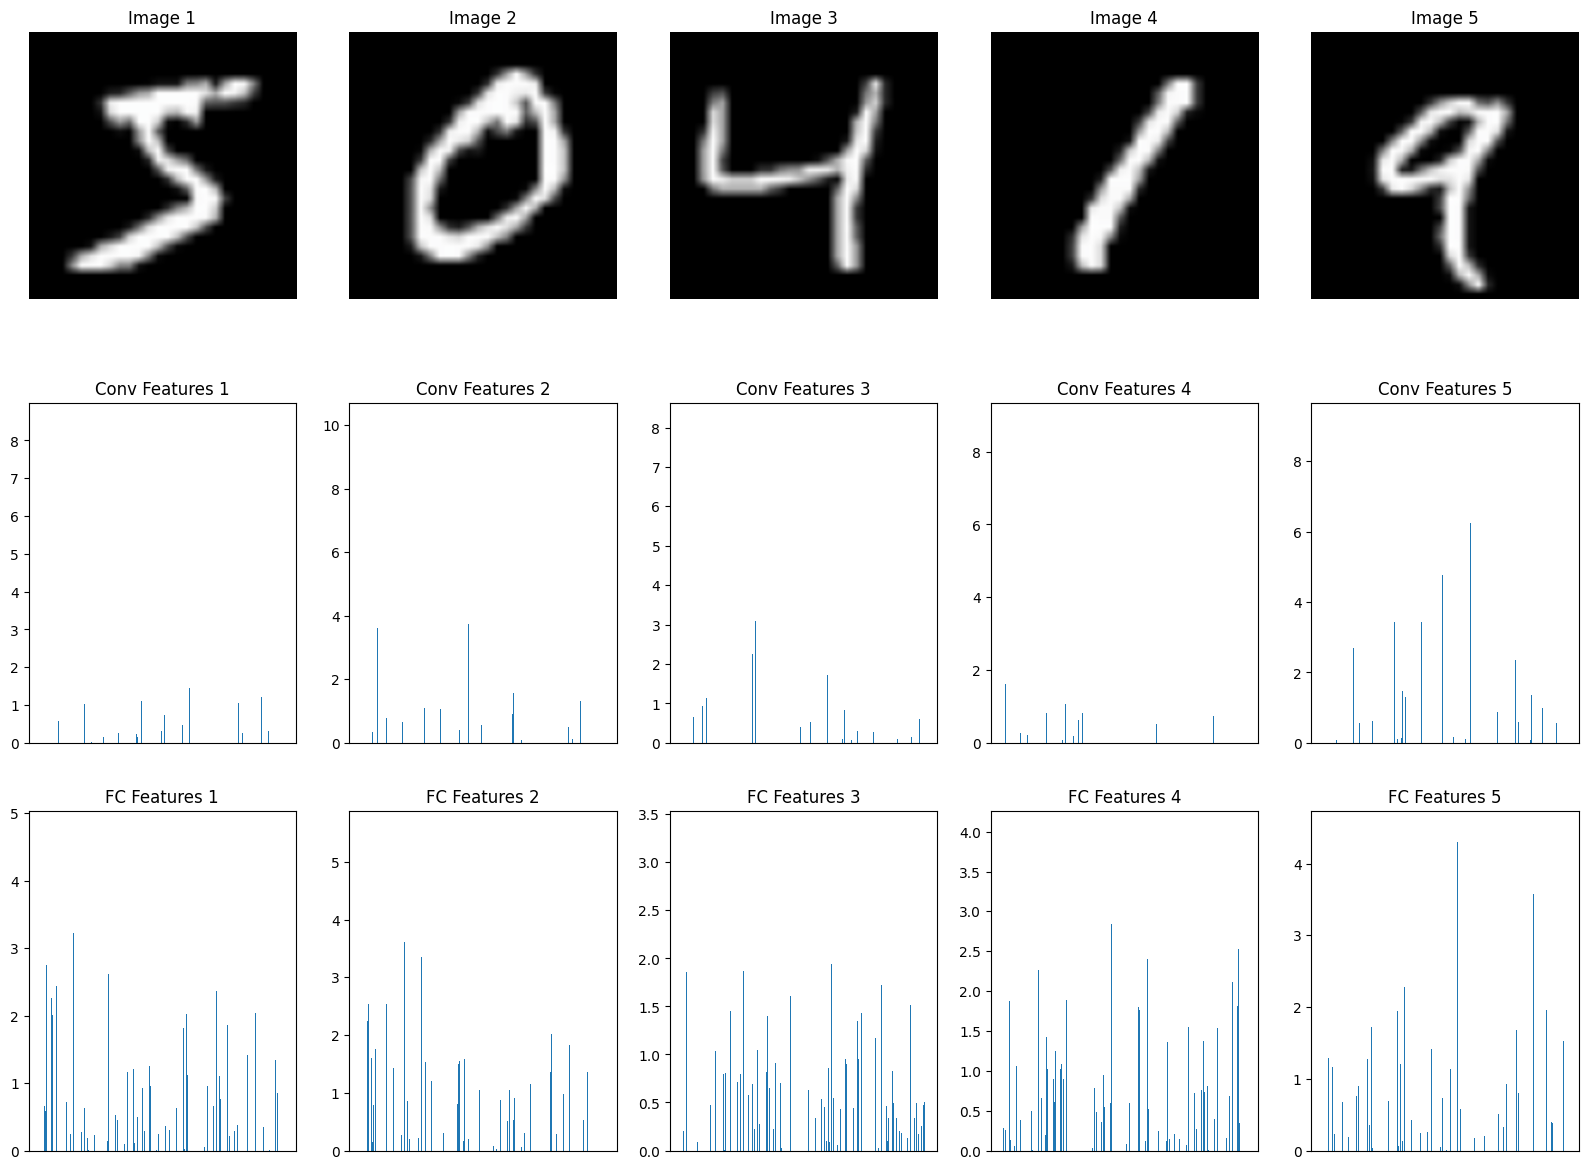

In [10]:
vgg16 = models.vgg16(pretrained=True).eval()

# Extract features from the last convolutional layer and final fully connected layer
def extract_features(image):
    with torch.no_grad():
        features = vgg16.features(image.unsqueeze(0))
        # Extract features from the last convolutional layer
        conv_features = features.view(features.size(0), -1)

        # Extract features from the final fully connected layer
        x = vgg16.avgpool(features)
        x = torch.flatten(x, 1)
        fc_features = vgg16.classifier[:-1](x)  # Exclude the final classification layer

    return conv_features, fc_features

# Visualize features for a few sample images
def visualize_sample_images(dataset, num_samples=5):
    fig, axs = plt.subplots(3, num_samples, figsize=(20, 15))
    for i in range(num_samples):
        image, _ = dataset[i]

        # Extract features
        conv_features, fc_features = extract_features(image)

        # Original image (convert from tensor to numpy and rearrange dimensions for display)
        image_np = np.transpose(image.numpy(), (1, 2, 0))
        image_np = (image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)
        axs[0, i].imshow(image_np)
        axs[0, i].axis('off')
        axs[0, i].set_title(f'Image {i+1}')

        # Display feature vector from the last convolutional layer
        axs[1, i].bar(range(len(conv_features[0])), conv_features[0].numpy())
        axs[1, i].set_title(f'Conv Features {i+1}')
        axs[1, i].set_xticks([])

        # Display feature vector from the final fully connected layer
        axs[2, i].bar(range(len(fc_features[0])), fc_features[0].numpy())
        axs[2, i].set_title(f'FC Features {i+1}')
        axs[2, i].set_xticks([])

    plt.show()

# Visualize features for a few sample images
visualize_sample_images(CNN_train_dataset)

**2. b**

Features from the last convolutional layer are better for image retrieval because they keep the details and diverse features of the image, providing a better representation. The final fully connected layer compresses this information into a simpler form, losing important relationships needed for retrieval.

# Q3 Similarity Measures


**3. a**

In [11]:
import math

def cosine_similarity(vec1, vec2):
    dot_product = sum(a * b for a, b in zip(vec1, vec2))
    magnitude_vec1 = math.sqrt(sum(a * a for a in vec1))
    magnitude_vec2 = math.sqrt(sum(b * b for b in vec2))
    if magnitude_vec1 == 0 or magnitude_vec2 == 0:
        return 0  # Avoid division by zero
    return dot_product / (magnitude_vec1 * magnitude_vec2)

def euclidean_distance(vec1, vec2):
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(vec1, vec2)))

**3. b**

Top-K similar images using Cosine Similarity:


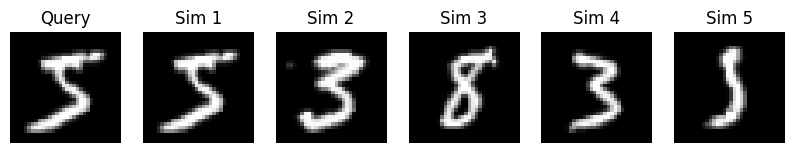

Top-K similar images using Euclidean Distance:


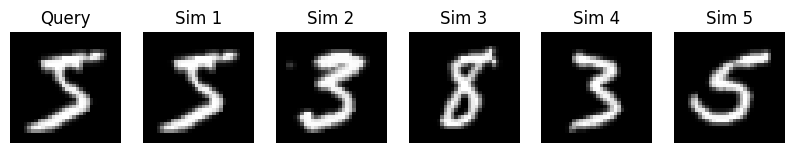

In [12]:
# Function to find top-K most similar images
def find_top_k_similar_images(query_image, database_images, k=5, similarity_metric='cosine'):
    similarities = []
    query_image_flat = query_image.flatten().numpy()
    for idx, db_image in enumerate(database_images):
        db_image_flat = db_image.flatten().numpy()
        if similarity_metric == 'cosine':
            similarity = cosine_similarity(query_image_flat, db_image_flat)
        elif similarity_metric == 'euclidean':
            similarity = -euclidean_distance(query_image_flat, db_image_flat)
        similarities.append((similarity, idx))

    # Sort by similarity and get top K
    similarities.sort(reverse=True, key=lambda x: x[0])
    top_k_indices = [idx for _, idx in similarities[:k]]
    return top_k_indices

# Display top-K similar images
def display_images(query_image, top_k_indices, database_images):
    plt.figure(figsize=(10, 2))
    plt.subplot(1, len(top_k_indices) + 1, 1)
    plt.imshow(query_image.squeeze(), cmap='gray')
    plt.title("Query")
    plt.axis('off')
    for i, idx in enumerate(top_k_indices):
        plt.subplot(1, len(top_k_indices) + 1, i + 2)
        plt.imshow(database_images[idx].squeeze(), cmap='gray')
        plt.title(f"Sim {i+1}")
        plt.axis('off')
    plt.show()

# Use a small subset of 300 images for demonstration
subset_size = 300
train_subset = torch.utils.data.Subset(train_dataset, range(subset_size))
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=subset_size, shuffle=False)

# Retrieve data and labels
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Query example
query_index = 0  # First image as query
query_image = images[query_index]
top_k = 5

# Find and display top-K similar images using Cosine Similarity
top_k_cosine = find_top_k_similar_images(query_image, images, top_k, similarity_metric='cosine')
print("Top-K similar images using Cosine Similarity:")
display_images(query_image, top_k_cosine, images)

# Find and display top-K similar images using Euclidean Distance
top_k_euclidean = find_top_k_similar_images(query_image, images, top_k, similarity_metric='euclidean')
print("Top-K similar images using Euclidean Distance:")
display_images(query_image, top_k_euclidean, images)

**3. c**

Based on the result, it seems that Euclidean distance have better a accuracy, as it prioritizes magnitude. Euclidean distance analysis distance between points better and cosine similarity analysis if the shapes are alike.

# Q4 Image Retrieval Pipeline


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


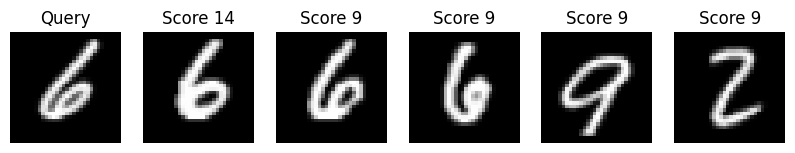

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import defaultdict
import torch
from torchvision import datasets, transforms


# Function to create a codebook using K-means clustering
def create_codebook(descriptors, k):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(descriptors)
    return kmeans

# Function to assign features to nearest cluster centers
def assign_features_to_clusters(descriptors, kmeans):
    return kmeans.predict(descriptors)

# Function to build an inverted index
def build_inverted_index(image_word_ids):
    inverted_index = defaultdict(list)
    for img_idx, words in enumerate(image_word_ids):
        for word in words:
            inverted_index[word].append(img_idx)
    return inverted_index

# Function to query the inverted index
def query_inverted_index(query_word_ids, inverted_index, top_k):
    image_scores = defaultdict(int)
    for word in query_word_ids:
        if word in inverted_index:
            for img_idx in inverted_index[word]:
                image_scores[img_idx] += 1
    sorted_images = sorted(image_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_images[:top_k]

# Function to display images
def display_images(query_image, retrieved_images, train_subset):
    plt.figure(figsize=(10, 2))
    plt.subplot(1, len(retrieved_images) + 1, 1)
    plt.imshow(query_image.squeeze(), cmap='gray')
    plt.title("Query")
    plt.axis('off')
    for i, (img_idx, score) in enumerate(retrieved_images):
        img = train_subset[img_idx][0].numpy().squeeze() * 255
        plt.subplot(1, len(retrieved_images) + 1, i + 2)
        plt.imshow(img, cmap='gray')
        plt.title(f"Score {score}")
        plt.axis('off')
    plt.show()

# Load dataset and use a subset for demonstration
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='mnist_data', train=False, transform=transform)


# Use a larger subset of images for demonstration
subset_size = 1000
train_subset = torch.utils.data.Subset(train_dataset, range(subset_size))
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=1, shuffle=False)

# Extract SIFT features for each image
all_descriptors = []
image_word_ids = []

for images, _ in train_loader:
    image = images[0]
    _, _, descriptors = extract_and_visualize_sift(image)
    if descriptors is not None:
        all_descriptors.extend(descriptors)

# Ensure there are enough descriptors
if len(all_descriptors) == 0:
    raise ValueError("No descriptors found in the dataset. Ensure the dataset contains images with detectable features.")

# Reshape the descriptors array properly
all_descriptors = np.array(all_descriptors)
if all_descriptors.ndim == 1:
    all_descriptors = all_descriptors.reshape(-1, 1)

# Check if there are enough descriptors before creating the codebook
min_descriptors = 50  # Minimum number of descriptors to form clusters
if len(all_descriptors) < min_descriptors:
    raise ValueError(f"Not enough descriptors to form clusters. Found {len(all_descriptors)} descriptors.")

# Create codebook using K-means clustering
k = 50  # Number of visual words, ensure k <= len(all_descriptors)
kmeans = create_codebook(all_descriptors, k)

# Assign descriptors to clusters for each image
for images, _ in train_loader:
    image = images[0]
    _, _, descriptors = extract_and_visualize_sift(image)
    if descriptors is not None:
        word_ids = assign_features_to_clusters(descriptors, kmeans)
        image_word_ids.append(word_ids)

# Build inverted index
inverted_index = build_inverted_index(image_word_ids)

# Process a query image
query_index = 0  # Ensure the query index is correct
query_image = images[query_index]
_, _, query_descriptors = extract_and_visualize_sift(query_image)
if query_descriptors is None:
    raise ValueError("No descriptors found in the query image. Ensure the query image has detectable features.")
query_word_ids = assign_features_to_clusters(query_descriptors, kmeans)

# Retrieve top-K similar images
top_k = 5
retrieved_images = query_inverted_index(query_word_ids, inverted_index, top_k)

# Display results
display_images(query_image, retrieved_images, train_subset)


# Q5 Vector Database Integration

In [1]:
pip install pinecone-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.2 MB/s eta 0:00:00


**5. a**

In [26]:
import os
from pinecone import Pinecone, ServerlessSpec

# Initialize Pinecone
api_key = 'e8809041-71e2-44fc-90d0-68fedc259c65'
pc = Pinecone(api_key=api_key)

# Create an index
index_name = 'mnist-vectors'
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=512,  # Assuming the feature vector size is 512
        metric='euclidean',
        spec=ServerlessSpec(
            cloud='aws',
            region='us-east-1'  # Use a supported region
        )
    )
index = pc.Index(index_name)

In [9]:
# Define data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 10
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

**5. b**

In [10]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        # Custom CNN architecture instead of ResNet
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjust input size based on your model's final feature map size
        self.fc2 = nn.Linear(128, 64)  # Output dimension of your feature vector

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        features = F.relu(self.fc2(x))
        return features

# Create an instance of the FeatureExtractor
feature_extractor = FeatureExtractor()


In [11]:
vectors = []
for batch_idx, (images, labels) in enumerate(train_loader):
    # Ensure the input matches the expected shape (grayscale)
    images = images[:, 0, :, :].unsqueeze(1)  # Convert to single-channel (unsqueeze 1)

    batch_features = feature_extractor(images)
    batch_features = batch_features.tolist()
    labels = labels.tolist()

    for i in range(len(batch_features)):
        # Generate a placeholder image path (since MNIST images are not from files)
        image_path = f"MNIST_image_{batch_idx * batch_size + i}.png"
        vector = {
            "id": str(len(vectors)),
            "values": batch_features[i],
            "metadata": {"label": labels[i],
                         "image_url": image_path}
        }
        vectors.append(vector)

# Print the number of vectors created
print("Number of vectors:", len(vectors))

Number of vectors: 60000


**5. c**

In [16]:
def retrieve_top_k(query_vector, vectors, k=10):
    # Convert vectors to a NumPy array of feature vectors
    feature_vectors = np.array([vector['values'] for vector in vectors])

    # Calculate cosine similarity or other similarity metric
    similarities = np.dot(feature_vectors, query_vector)
    top_indices = similarities.argsort()[::-1][:k]
    return top_indices

In [19]:
ground_truth = np.array([vector['metadata']['label'] for vector in vectors])
feature_vectors = np.array([vector['values'] for vector in vectors])

# Initialize lists to store precision and recall values
precisions = []
recalls = []
average_precisions = []


In [20]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [ ]:
# Loop over each query vector
for query_idx in range(len(vectors)):
    query_vector = feature_vectors[query_idx]
    query_label = ground_truth[query_idx]

    # Retrieve top-k similar vectors
    retrieved_indices = retrieve_top_k(query_vector, vectors)
    retrieved_labels = [vectors[idx]['metadata']['label'] for idx in retrieved_indices]

    # Calculate precision and recall
    tp = sum([1 for label in retrieved_labels if label == query_label])
    precision = tp / len(retrieved_indices)
    recall = tp / len(np.where(ground_truth == query_label)[0])

    # Store precision and recall values
    precisions.append(precision)
    recalls.append(recall)

    # Calculate average precision (AP)
    y_true = [1 if vectors[idx]['metadata']['label'] == query_label else 0 for idx in retrieved_indices]
    y_scores = np.dot(feature_vectors[retrieved_indices], query_vector)
    ap = average_precision_score(y_true, y_scores)
    average_precisions.append(ap)

# Compute mean Average Precision (mAP)
mAP = np.mean(average_precisions)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class f

In [ ]:
plt.figure()
plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve: mAP={mAP:.2f}')
plt.show()